<a href="https://colab.research.google.com/github/tgi25/home/blob/master/Saliency_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sailiency Maps

[For more details](https://www.coderskitchen.com/explainable-ai-how-to-implement-saliency-maps/#)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## A few helper functions to load an arbitrary image and generate a simple grey-value heatmap

In [ ]:
def prep_input(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def norm_flat_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm
    
def get_lion():
    # Wikipedia lion image https://en.wikipedia.org/wiki/Lion#/media/File:Lion_waiting_in_Namibia.jpg
    # License: CC BY 2.0 https://creativecommons.org/licenses/by/2.0/deed.en
    import urllib.request
    filename = 'lion.jpg'
    img_url = r"https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg"
    urllib.request.urlretrieve(img_url, filename)

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")

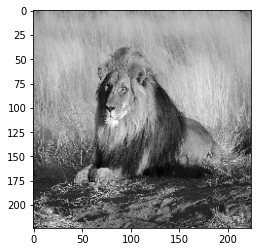

In [ ]:
test_model = tf.keras.applications.densenet.DenseNet201()
#test_model.summary()
get_lion()
img_path = "lion.jpg"
input_img = prep_input(img_path)
input_img = tf.keras.applications.densenet.preprocess_input(input_img)
plt.imshow(norm_flat_image(input_img[0]), cmap = "gray")

When we run inference with the lion test image, we get a prediction vector back.

In [ ]:
result = test_model(input_img)
max_idx = tf.argmax(result,axis = 1)
tf.keras.applications.imagenet_utils.decode_predictions(result.numpy())

49152/35363 [=========================================] - 0s 0us/step


[[('n02129165', 'lion', 0.99636406),
  ('n02106030', 'collie', 0.002750164),
  ('n02105855', 'Shetland_sheepdog', 0.0004229169),
  ('n02130308', 'cheetah', 0.00014136494),
  ('n02412080', 'ram', 5.2282045e-05)]]

## Vanilla backprop for saliency map

After setting everything up, we have to explicitly instruct TF to calculate and keep the gradients for the input image input_img.

In [ ]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = test_model(input_img)
    max_score = result[0,max_idx[0]]
grads = tape.gradient(max_score, input_img)

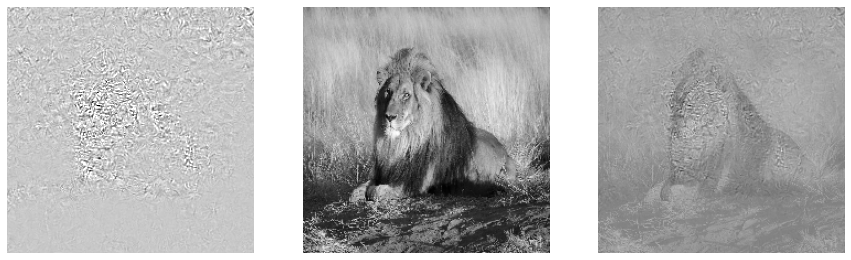

In [ ]:
plot_maps(norm_flat_image(grads[0]), norm_flat_image(input_img[0]))